# Workaround Example for Cleaning Residual 1/f Noise in NIRSpec Darks
--------------------------------------------------------------------------------------------------------
**Latest update**: November 13, 2023.

## Notebook Goals
Produce a cleaned dark rate file to test the NSClean operation.

## Introduction

This workaround is intended to address a known issue with NIRSpec pipeline products: negative and/or surplus flux in the extracted 1-D spectrum is seen, typically with an irregular wavelength-dependent undulation. The cause of this artifact is correlated noise from low-level detector thermal instabilities, seen as vertical banding in 2-D count rate images, particularly in exposures of the NRS2 detector. While the IRS2 readout mode reduces this effect, it is not completely eliminated.

This workaround uses an external package, developed by Bernard Rauscher, called [NSClean](https://webb.nasa.gov/content/forScientists/publications.html#NSClean), which uses dark areas of the detector to fit a background model to the data in Fourier space.  It requires an input mask to identify all dark areas of the detector. The more thorough and complete this mask is, the better the background fit.  In this notebook, we will sigma-clip the data to create a mask from the unilluminated data in the image.  In some cases, this mask may not be complete enough for the best possible noise removal.  If needed, see the NSClean documentation for some suggestions on manually creating a custom mask.

This notebook uses as an example a dark observation from program 1484.

Use this workaround until a residual cleaning algorithm is incorporated into the pipeline.

## Set up

Prior to running this notebook, you will need to install the JWST pipeline and an external package called NSClean, developed by B. Rauscher.

It is recommended to install these packages into a new environment.  For example, using Anaconda:

```
conda create -n nsclean python=3.11
conda activate nsclean
```

Then, the latest pipeline and supporting packages can be installed via pip:

```
pip install jwst matplotlib jupyter pandas
```

If you have not used the pipeline before, you may also need to set some environment variables for retrieving reference data from CRDS, following the pipeline [Quickstart Guide](https://jwst-pipeline.readthedocs.io/en/latest/getting_started/quickstart.html).

Finally, download the latest version of the [NSClean code](https://webb.nasa.gov/content/forScientists/publications.html#NSClean). Unpack the archive and install the contained code with the command below.

For the latest version at time of writing (NSClean v1.9), the archive contains a directory called `nsclean_1.9`. The code may be installed with:

```
pip install -e nsclean_1.9
```

After installing all required packages, restart the jupyter server from the nsclean environment and open this notebook.  For example, from the directory containing this notebook, run:
```
jupyter notebook
```
and select this file.

Running the following cell, containing package imports, should now succeed.

Import necessary packages and print the calibration pipeline version and current context.

In [1]:
import json
import logging
import os
import requests
import warnings

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip

import jwst
import nsclean
from jwst import datamodels
from jwst.datamodels import dqflags
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
from stpipe import crds_client

# hide all log and warning messages
logging.disable(logging.ERROR)
warnings.simplefilter('ignore', RuntimeWarning)

# print current jwst versions
print(f"JWST calibration pipeline version: {jwst.__version__}")
print(f"Current CRDS context: {crds_client.get_context_used('jwst')}")

JWST calibration pipeline version: 1.12.1
Current CRDS context: jwst_1147.pmap


Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create a list of filenames. Download the data from MAST.

In [3]:
# full-frame dark
obs_ids = ['jw01484177001_04201_00001']
detectors = [1, 2]

# specify rate data products
uncal_names = []
for obs_id in obs_ids:
    for detector in detectors:
        uncal_names.append(f'{obs_id}_nrs{detector}_uncal.fits')
        
# download all the FITS files
for name in uncal_names:
    print(f'Downloading {name}')
    if not os.path.isfile(name):
        get_jwst_file(name)

## Create a rate file

The pipeline does not normally create rate files from dark input.  Make rate files here with the detector1 pipeline.

Run Detector1Pipeline on the input data. This will take some time to complete.

In [4]:
rate_names = []
for uncal_file in uncal_names:
    outname = uncal_file.replace('uncal', 'rate')
    rate_names.append(outname)
    if os.path.isfile(outname):
        print(f'Using file on disk: {outname}')
        continue
    
    # process rate data
    print(f'Processing {os.path.basename(uncal_file)}...')
    Detector1Pipeline.call(uncal_file, save_results=True)

    # save to disk
    outname = uncal_file.replace('uncal', 'rate')
    print(f'Saved {os.path.basename(outname)}\n')

    

Using file on disk: jw01484177001_04201_00001_nrs1_rate.fits
Using file on disk: jw01484177001_04201_00001_nrs2_rate.fits


## Create a mask for the rate file

The goal in creating the mask is to identify any pixel that is unilluminated.  That is, the mask must contain True and False values, where True indicates that the pixel is dark, and False indicates that the pixel is illuminated (not dark).

Here, we mark the following detector areas as illuminated, non-dark areas (False):

- 3-sigma outliers
- any pixel set to NaN in the rate data.

To tune the outlier detection in this mask, try modifying the n_sigma parameter below.  A higher value will identify fewer outliers. A lower value will identify more.

Create and save a mask identifying dark areas of the detector.

In [5]:
# scale parameter for identifying outliers
n_sigma = 3.0

mask_names = []
for rate_file in rate_names:
    # copy SCI data from rate file
    with fits.open(rate_file) as hdul:
        rate_sci = hdul['SCI'].data.copy()

    # initialize mask with everything set to True
    mask = np.full(np.shape(rate_sci), True)
        
    # find NaNs from the rate file
    # set them to 0 in the rate data and False in the mask
    is_nan = np.isnan(rate_sci)
    rate_sci[is_nan] = 0
    mask[is_nan] = False

    # keep the left and right reference pixel columns
    mask[:, :5] = True
    
    # keep one extra column on the right, since it is always empty for NRS1
    mask[:, -5:] = True

    # get clipped stats to flag n-sigma outliers and ignore them in the mask
    _, med, sig = sigma_clipped_stats(rate_sci, mask=~mask, mask_value=0, sigma=5.0)
    outliers = np.where(rate_sci > med + n_sigma * sig)
    mask[outliers] = False

    # save the mask to disk
    outname = rate_file.replace('rate', 'mask')
    fits.writeto(outname, mask.astype(np.uint8), overwrite=True)
    print(f"Saved {outname}") 

    mask_names.append(outname)

Saved jw01484177001_04201_00001_nrs1_mask.fits
Saved jw01484177001_04201_00001_nrs2_mask.fits


## Verify the mask keeps only unilluminated data

Check the mask against the rate data to make sure it keeps only dark areas of the detector.

In this example, note that there are still some remaining illuminated areas, primarily due to transient artifacts like cosmic rays and snowballs.

Plot the rate data with masked areas blocked.

In [6]:
# define a helper function for data plotting

def plot_dark_data(rate_file, mask_file, layout='rows'):

    # make a matplotlib figure
    if layout == 'rows':
        fig, ax = plt.subplots(3, 1, figsize=(10, 5))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    plt.suptitle(f'Dark areas for {os.path.basename(rate_file)}')

    # open the mask and science data
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data

    with fits.open(rate_file) as hdulist:
        sci = hdulist['SCI'].data

    # get data limits from the dark data
    masked_sci = sci.copy()
    masked_sci[mask == 0] = 0
    vmin = np.nanpercentile(masked_sci, 1)
    vmax = np.nanpercentile(masked_sci, 99)

    # plot the science image with limits from the dark data
    sci[np.isnan(sci)] = 0
    ax[0].imshow(sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[0].set_title('Rate data')

    # plot the mask: values are 1 or 0
    ax[1].imshow(mask, origin='lower', vmin=0, vmax=1)
    ax[1].set_title('Mask')

    # plot the dark data with the same limits as the science data
    ax[2].imshow(masked_sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[2].set_title('Dark data')

    fig.tight_layout()

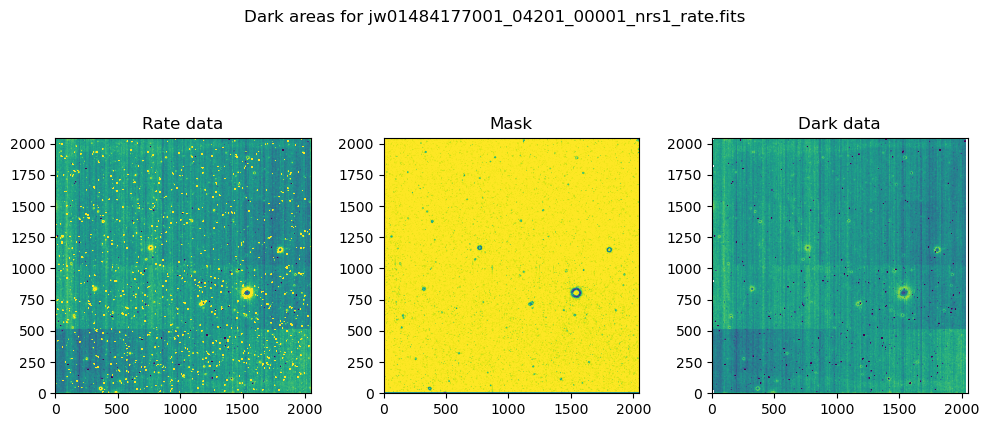

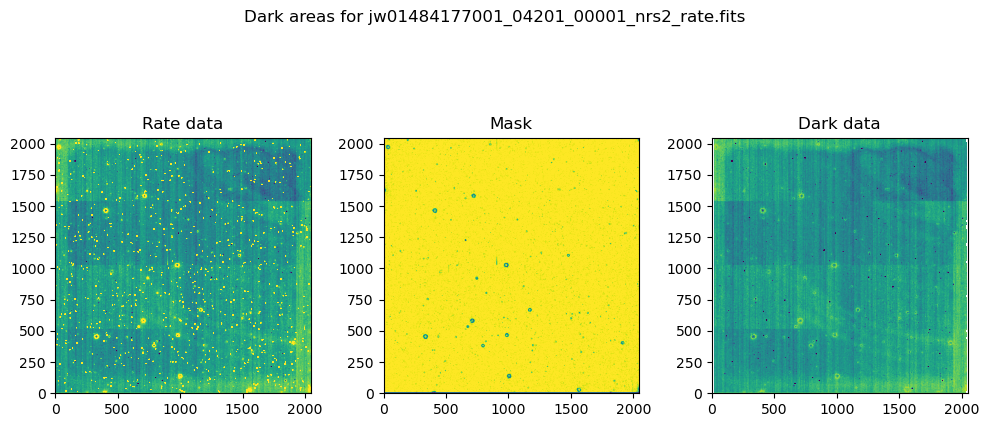

In [7]:
# plot each associated set of rate data and mask file
for rate_file, mask_file in zip(rate_names, mask_names):
    plot_dark_data(rate_file, mask_file, layout='cols')

## Use the mask to clean the rate data

We can use the NSClean package with the created mask to update the rate data, removing residual noise.

In some situations, the cleaning step may fail to find a fit to the background noise.  In the cell below, the error from the failure is caught and a "Cannot clean" message is shown for the file instead.

This failure may occur if the mask does not contain enough dark data (marked True).  In particular, every column in the mask except for the first and last 4 columns must contain some pixels marked True.  The background fitting procedure considers each column, one at a time, so it will crash if there is no data in a column to fit.

If you're getting error messages from the step below, check that your mask in the image above has at least some True values in every column.

Note that in NSClean there is a different interface for subarray and full-frame rates files (NSCleanSubarray and NSClean, respectively). Here, we check the shape of the input data to determine which to instantiate.

For each file, instantiate the cleaner with the mask, then call the clean function.

In [8]:
# define a helper function to clean subarray data

def clean_subarray(sci, mask, detector):
    # subarray data must be transposed and flipped to detector 
    # space before cleaning
    if detector=='NRS2':
        data = sci.transpose()[::-1]
        data_mask = mask.transpose()[::-1]
    else:
        # no flip required for NRS1
        data = sci.transpose()
        data_mask = mask.transpose()
    
    cleaner = nsclean.NSCleanSubarray(data, data_mask)
    try:
        cleaned_data = cleaner.clean()
    except np.linalg.LinAlgError:
        print(f'Cannot clean {os.path.basename(rate_file)}')
        return None

    # restore original orientation
    if detector=='NRS2':
        cleaned_sci = cleaned_data[::-1].transpose()
    else:
        cleaned_sci = cleaned_data.transpose()

    return cleaned_sci

In [9]:
# define a helper function to clean full frame data

def clean_full_frame(sci, mask, detector):
    cleaner = nsclean.NSClean(detector, mask)
    try:
        cleaned_sci = cleaner.clean(sci)
    except np.linalg.LinAlgError:
        print(f'Cannot clean {os.path.basename(rate_file)}')
        return None
    return cleaned_sci

In [10]:
# define a helper function to clean each file as appropriate

def clean(rate_file, mask_file, suffix='rate_cleaned'):
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data.astype(bool)

    rate_hdulist = fits.open(rate_file)
    sci = rate_hdulist['SCI'].data
    detector = rate_hdulist[0].header['DETECTOR']
    
    # set NaN values to zero
    is_nan = np.isnan(sci)
    sci[is_nan] = 0
    
    # instantiate the cleaner and clean the data
    if sci.shape != (2048, 2048):
        cleaned_sci = clean_subarray(sci, mask, detector)
    else:
        cleaned_sci = clean_full_frame(sci, mask, detector)

    if cleaned_sci is None:
        return
    
    # restore NaNs
    cleaned_sci[is_nan] = np.nan  # restore NANs

    # save result
    rate_hdulist['SCI'].data = cleaned_sci

    outname = rate_file.replace('rate', suffix)
    rate_hdulist.writeto(outname, overwrite=True)
    rate_hdulist.close()
    print(f'Saved {os.path.basename(outname)}')
    
    return outname

In [11]:
# clean each rate file with its associated mask

cleaned_rate_names = []
for rate_file, mask_file in zip(rate_names, mask_names):
    outname = clean(rate_file, mask_file)
    cleaned_rate_names.append(outname)

Saved jw01484177001_04201_00001_nrs1_rate_cleaned.fits
Saved jw01484177001_04201_00001_nrs2_rate_cleaned.fits


## Check the cleaned data

We can now compare the cleaned data to the original rate file and verify that the noise has been removed.

In many cases, the cleaning process introduces new artifacts to the rate file.  These should be carefully examined and weighed against the benefits of the noise reduction.  If transient artifacts like snowballs are interfering with the cleaning process, it may be beneficial to manually edit the mask to remove these areas from consideration in the background fit. To do so, try varying the outlier detection above, or editing specific pixels in the mask array directly.  Otherwise, see the NSClean documentation for some more suggestions on manual editing.

Note that in the images below, there are scattered values with large relative differences from the original rate file (the relative difference image on the left, below).  These are artifacts of the cleaning process.  

There are also broader low-level residual background effects (the relative difference image on the right, below, with scattered outliers hidden).  These include the background patterns we are trying to remove: the 1/f noise variations in the dispersion direction and the picture frame effect at the top and bottom of the frame.  However, there may also be low-level artifacts introduced by over-fitting the dark data in the cleaning process.

Check both residual images carefully to understand the impact of the cleaning process on your data.

Plot the original and cleaned data, as well as a residual map.

In [12]:
# define a helper function for plotting the cleaned data

def plot_cleaned_data(rate_file, cleaned_file, layout='rows', scale=1.0):

    # make a matplotlib figure
    if layout == 'rows':
        fig, ax = plt.subplots(4, 1, figsize=(10, 5))
    else:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.flat
    plt.suptitle(f'Cleaned data for {os.path.basename(rate_file)}')

    # open the original and cleaned data
    with fits.open(rate_file) as hdulist:
        original = hdulist['SCI'].data

    with fits.open(cleaned_file) as hdulist:
        cleaned = hdulist['SCI'].data

    # define image limits from the original data
    vmin = np.nanpercentile(original, scale)
    vmax = np.nanpercentile(original, 100 - scale)

    # plot the original data
    original[np.isnan(original)] = 0
    cleaned[np.isnan(cleaned)] = 0
    ax[0].imshow(original, origin='lower', vmin=vmin, vmax=vmax)
    ax[0].set_title('Original rate data')

    # plot the cleaned data with the same image limits
    ax[1].imshow(cleaned, origin='lower', vmin=vmin, vmax=vmax)
    ax[1].set_title('Cleaned rate data')

    # plot the relative difference between the original and cleaned data
    diff = (original - cleaned) / original
    diff[~np.isfinite(diff)] = 0
    vmin = np.nanpercentile(diff, 1)
    vmax = np.nanpercentile(diff, 99)
    ax[2].imshow(diff, origin='lower', vmin=vmin, vmax=vmax)
    ax[2].set_title('Relative difference')

    # plot the relative difference again, this time hiding the outliers so that low-level
    # background changes can be seen
    hide_outliers = np.ma.filled(sigma_clip(diff, masked=True), fill_value=0)
    vmin = np.nanpercentile(hide_outliers, 1)
    vmax = np.nanpercentile(hide_outliers, 99)
    ax[3].imshow(hide_outliers, origin='lower', vmin=vmin, vmax=vmax)
    ax[3].set_title('Relative difference with outliers hidden')

    fig.tight_layout()

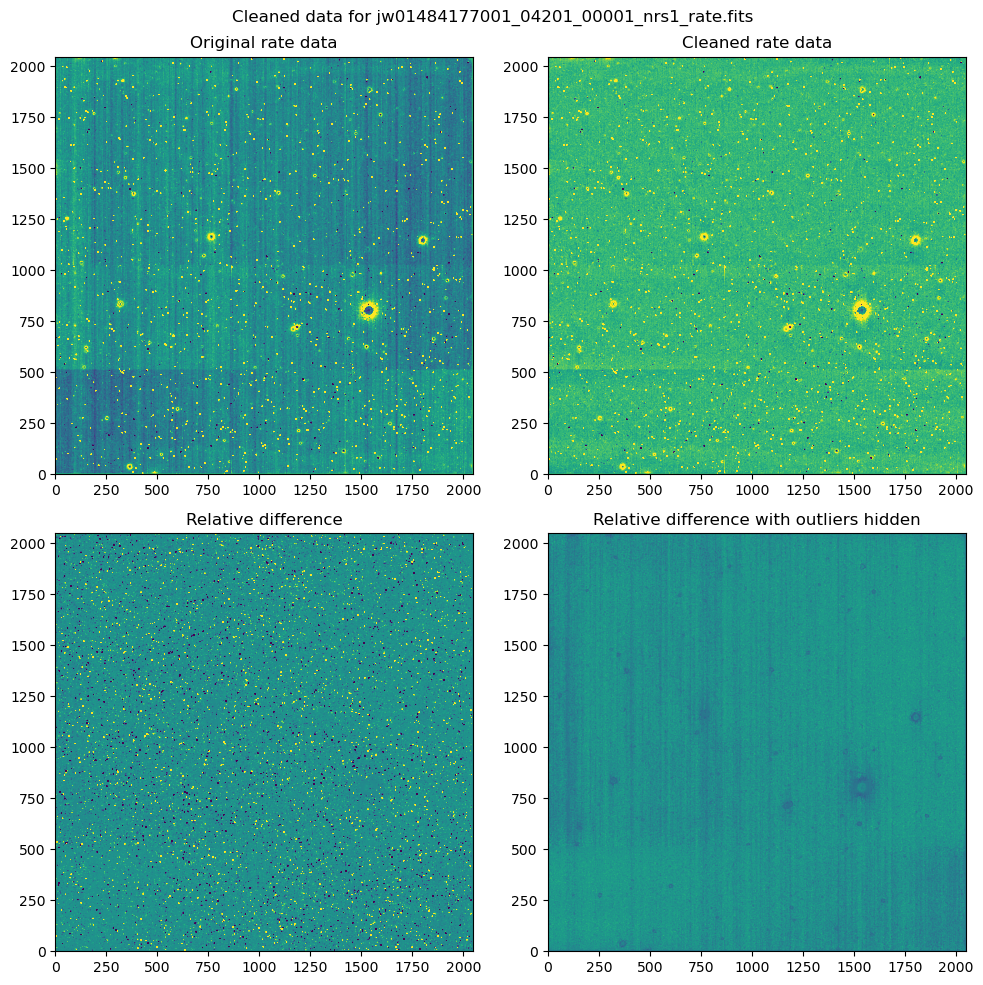

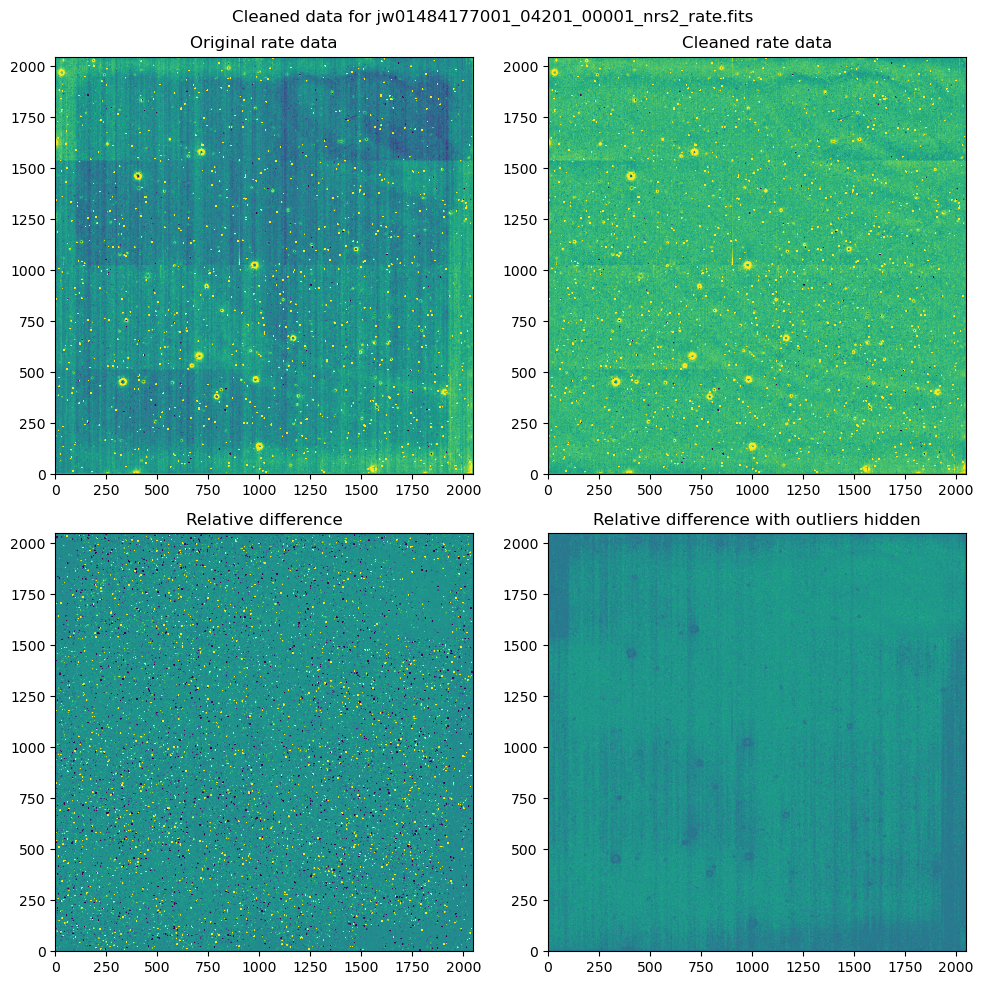

In [13]:
# plot each set of original and cleaned rate files
for rate_file, cleaned_file in zip(rate_names, cleaned_rate_names):
    if cleaned_file is None:
        continue
    plot_cleaned_data(rate_file, cleaned_file, layout='cols', scale=1)